## Modelo NLP - Análisis de críticas positivas y negativas

### 1. Lectura de dataset de IMDb

In [1]:
import pandas as pd

df = pd.read_csv('movie_data.csv',encoding = 'utf-8'
                 )
df.head(5)

,review,sentiment
0,"In 1974, the teenager Martha Moxley (Maggie Gr...",1
1,OK... so... I really like Kris Kristofferson a...,0
2,"***SPOILER*** Do not read this, if you think a...",0
3,hi for all the people who have seen this wonde...,1
4,"I recently bought the DVD, forgetting just how...",0


### 2. Exploración y Limpieza de datos

#### a) Análisis de variable a predecir

Lo primero que haremos es hacer un breve analisis de la varible a predecir, para ver si estamos en presencia de una dataset balanceado o desbalanceado y, en función de ello, si debemos realizar algun tratamiento adicional.

/Users/santiagodellavedova/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='sentiment', ylabel='count'>

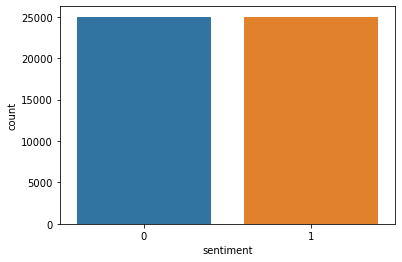

In [2]:
import seaborn as sns

sns.countplot("sentiment",data=df)

In [3]:
print("Reviews Positivas: " , df[df["sentiment"]==1]["sentiment"].count())
print("Reviews Negativas: " , df[df["sentiment"]==0]["sentiment"].count())

Reviews Positivas:  25000
Reviews Negativas:  25000


Como podemos ver, el dataset esta perfectamente balanceado por lo que no existiran sesgos a la hora de crear y entrenar el modelo y no se requeriran tecnicas como oversampling y subsampling para corregir el desbalanceo. 

#### b) Analisis de reviews con Nube de Palabras.

In [6]:
!pip install wordcloud 

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt

In [7]:
wordcloud = WordCloud(width = 800,
                      height = 400,
                      colormap = "hot")

In [8]:
lista_palabras = []
for i in range(len(df)):
    lista_palabras.append(df["review"][i])
texto_entero = " ".join(lista_palabras)

wordcloud.generate(texto_entero)

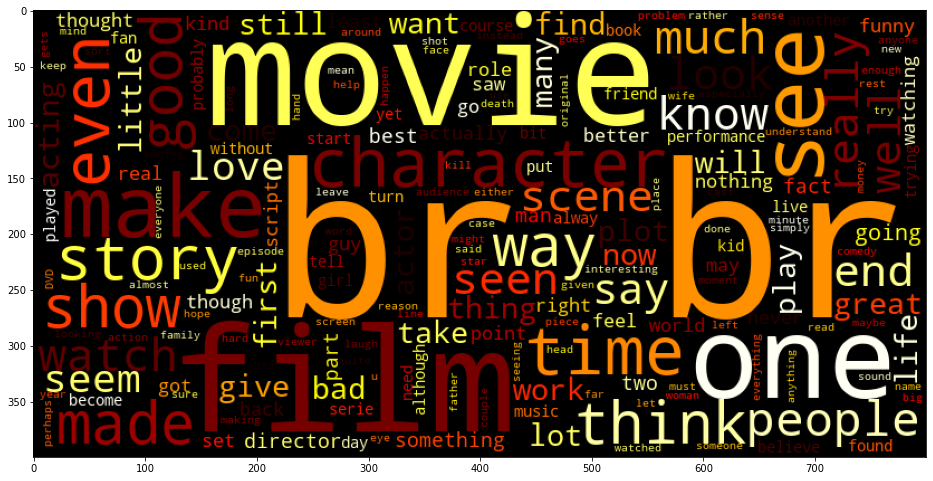

In [9]:
plt.figure(figsize = (16, 16), 
           facecolor = None)
plt.imshow(wordcloud)

Como podemos observar a partir de la nube de palabras, el mayor contenido de las reviews está dado por las palabras "movie" y "film" y por las etiquetas de HTML "br" que no aportan valor al análisis y pueden distorsionar el mismo. Es por esto que a continuación realizaremos una limpieza del dataset para eliminar etiquetas HTML, algunos emoticones y palabras vacias. 

#### c) Eliminación de marcadores HTML, emoticones irrelevantes

In [10]:
#prueba de funcionamiento
df.loc[0, 'review'][-50:]

'is seven.<br /><br />Title (Brazil): Not Available'

Se procede a limpiar texto y extraer caracteres no relevantes para el análisis (marcadores de HTML y marcas de puntuación).

In [11]:
#limpieza dataset
import re
def limpieza(text):
    text = re.sub('<[^>]*>', '', 
                  text) #con esta linea buscamos eliminar todos los marcadores HTML de las criticas.
    emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)',
                           text) #Guardamos los emoticones que se encuentren en la crítica en una variable.
    text = (re.sub('[\W]+', ' ', 
                   text.lower()) + 
            ' '.join(emoticons).replace('-', ''))
    return text

In [12]:
limpieza(df.loc[0, 'review'][-50:])

'is seven title brazil not available'

In [13]:
#contemplamos dejar emoticones que refieran a "like" o "dislike", ya que se toman dentro del scope del modelo
limpieza("<br> hola :) ,! :(   :-)!")

' hola :) :( :)'

In [14]:
df['review'] = df['review'].apply(limpieza)

In [15]:
df.head()

,review,sentiment
0,in 1974 the teenager martha moxley maggie grac...,1
1,ok so i really like kris kristofferson and his...,0
2,spoiler do not read this if you think about w...,0
3,hi for all the people who have seen this wonde...,1
4,i recently bought the dvd forgetting just how ...,0


#### Comprobación de cambios

In [16]:
wordcloud1 = WordCloud(stopwords = STOPWORDS,
                       width = 800,
                       height = 400,
                       colormap = "hot") 
#Incluimos el parametro stopword para eliminar las palabras vacias. 

In [17]:
lista_palabras1 = []
for i in range(len(df)):
    lista_palabras1.append(df["review"][i])
texto_entero1 = " ".join(lista_palabras1)
texto_entero1 = texto_entero1.replace(" s "," ")
wordcloud1.generate(texto_entero1)

Text(0.5, 1.0, 'Nube de Palabras')

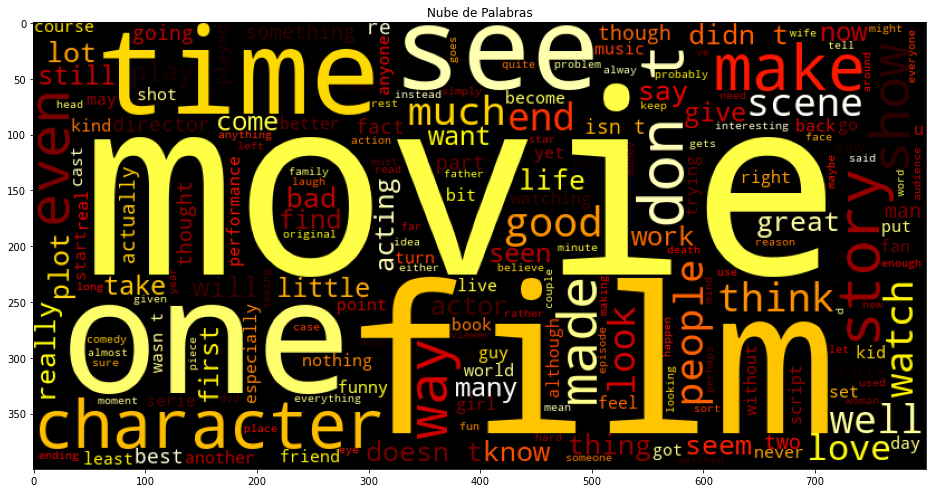

In [18]:
plt.figure(figsize = (16, 16), 
           facecolor = None)
plt.imshow(wordcloud1)
plt.title("Nube de Palabras")

Ahora sí la nube de palabras solo cuenta con palabras que son relevantes para el análisis de sentimientos a realizar. 

#### d) Utilización de stopwords para eliminar palabras vacías.

In [19]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/santiagodellavedova/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/santiagodellavedova/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

Eliminacion palabras vacías o sin significado para el modelo.

In [20]:
from nltk.corpus import stopwords

stopwords = stopwords.words('english')

#Lista de stopwords en inglés
print(stopwords)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [21]:
#Sin sopwords
review = df['review'][3]
review

'hi for all the people who have seen this wonderful movie im sure thet you would have liked it as much as i i love the songs once you have seen the show you can sing along as though you are part of the show singing and dancing dancing and singing the song one is an all time fave musical song too and the strutters at the end with the mirror its so oh you have to watch this one'

In [22]:
def depuracion(review):
    review_sin_depurar = nltk.tokenize.word_tokenize(review)
    review_depurada = [i for i in review_sin_depurar if i not in stopwords]
    return " ".join(review_depurada)

df["review"] = df["review"].apply(depuracion)

In [23]:
#Con stopwords
df['review'][3]

'hi people seen wonderful movie im sure thet would liked much love songs seen show sing along though part show singing dancing dancing singing song one time fave musical song strutters end mirror oh watch one'

Como podemos ver, a partir del metodo stopwords de la libreria nltk, eliminamos todas aquellas palabras vacias que no aportan al desarrollo del modelo. 

### 3. Creación y entrenamiento de modelo

In [24]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer

Utilizamos CountVectorizer y TfidfTransformer para contar las veces que una palabra aparece en una review y visualizar el valor ponderado de cada palabra en cada review y en el total de las reviews basado en el modelo de TF-IDF. 
Así mismo, decidimos probar con distintos modelos la realización del entrenamiento y verificar cuál es el más asertivo.

#### Utilización de LogisticRegression para entrenamiento de modelo

In [25]:
#Utiización de Pipeline para realizar el procesamiento
pipeline = Pipeline([
    ('bow', CountVectorizer()),  
    ('tfidf', TfidfTransformer()), 
    ('classifier', RandomForestClassifier(random_state = 42)), 
])

In [26]:
X = df['review']
y = df['sentiment']
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y,
                                                    test_size = 0.30,
                                                    random_state = 101)

In [27]:
entrenado = pipeline.fit(X_train,y_train)

In [28]:
predictions = pipeline.predict(X_test)

### 4. Evaluación del Modelo

In [29]:
from sklearn.metrics import confusion_matrix,classification_report
matriz_confusion = confusion_matrix(y_test,predictions)
print(classification_report(y_test,predictions))

#Valor 0: crítica negativa -- Valor 1: crítica positiva
pd.DataFrame(data = matriz_confusion,
             columns = ["Modelo: 0", "Modelo: 1"],
             index = ["Realidad: 0", "Realidad 1"])

              precision    recall  f1-score   support

           0       0.91      0.89      0.90      7514
           1       0.89      0.91      0.90      7486

    accuracy                           0.90     15000
   macro avg       0.90      0.90      0.90     15000
weighted avg       0.90      0.90      0.90     15000



,Modelo: 0,Modelo: 1
Realidad: 0,6657,857
Realidad 1,693,6793


#### Prueba de funcionamiento modelo

In [30]:
#Define si la crítica será positiva o negativa
entrenado.predict(["the movie is good", "the movie is bad"])

array([1, 0])

In [31]:
#Le asigna un porcentaje de probabilidad a la crítica
entrenado.predict_proba(["the movie is good"])

array([[0.12975614, 0.87024386]])

Podemos ver que el modelo predice bien dos críticas simples que le hemos pasado, siendo el porcentaje de acierto aproximadamente 87%

### 5. Interfaz gráfica

In [32]:
import tkinter as tk
from tkinter import ttk
from tkinter import  Text
try:
    from ctypes import windll
    windll.shcore.SetProcessDpiAwareness(1)
except:
    pass

try:
    from ctypes import windll
    windll.shcore.SetProcessDpiAwareness(1)
except:
    pass

In [33]:
def clasificar_critica():
    critica = critica_usuario.get()
    resultado = entrenado.predict([critica])
    
    if resultado == [0]:
        resultado_critica.config(text="NEGATIVA")
    else:
        resultado_critica.config(text="POSITIVA")

In [34]:
raiz= tk.Tk()
raiz.title("Clasificador Criticas de Cine")
raiz.geometry("1050x100")

frame=tk.Frame(raiz)
frame.grid()


critica_usuario=tk.StringVar()

label1 = ttk.Label(frame,text="Crítica: ")
entry1 = ttk.Entry(frame,width=100,textvariable=critica_usuario)
resultado_critica = ttk.Label(frame,text="¿Positiva o Negativa?",justify="center")
boton1 = ttk.Button(frame,text="Ejecutar!",command=clasificar_critica)


label1.grid(row=1,column=1)
entry1.grid(row=1, column=2)
boton1.grid(row=3,column=1,columnspan = 2,pady=12)
resultado_critica.grid(row=4,column=2)

raiz.mainloop()